In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import correlation
from tqdm import tqdm
import data_preprocessing;

### Read all clustered and sentimented files

In [115]:
folder = "files/"
clusters_w_sw = pd.read_csv(folder + "clusterized_tweets_with_stopwords.csv")
clusters_no_sw = pd.read_csv(folder + "clusterized_tweets_without_stopwords.csv")
sentiments_w_sw = pd.read_csv(folder + "sentimented_tweets_with_stopwords.csv")
sentiments_no_sw = pd.read_csv(folder + "sentimented_tweets_without_stopwords.csv")
stocks = pd.read_csv(folder + "clean_stocks.csv")
clusters_w_sw.date = pd.to_datetime(clusters_w_sw.date)
clusters_no_sw.date = pd.to_datetime(clusters_no_sw.date)
sentiments_w_sw.date = pd.to_datetime(sentiments_w_sw.date)
sentiments_no_sw.date = pd.to_datetime(sentiments_no_sw.date)
stocks.date = pd.to_datetime(stocks.date)


In [116]:
#function that combines three dataframes into one 
def combine_dataframes(clusters, sentiments):
    merged = pd.merge(clusters, sentiments, on = ['date','tweet', 'language', 
    'hashtags', 'cashtags',
    'link', 'retweet', 'nlikes', 
    'nreplies', 'nretweets', 'reply_to'], how = 'inner')
    merged = data_preprocessing.cut_dates(merged)
    merged['interactions'] = merged['nlikes'] + merged['nreplies'] + merged['nretweets']
    merged = merged.drop(columns=['nlikes', 'nreplies', 'nretweets'])
    popular = merged.groupby('date').max('interactions').merge(merged[['date', 'tweet']], on = 'date', how = 'right')
    popular.date = popular.date.dt.normalize()
    joined = pd.merge(popular, stocks, on = 'date', how = 'inner')
    return joined

## Analysis of tweets with stopwords

In [117]:
combined_w_sw = combine_dataframes(clusters_w_sw, sentiments_w_sw)

Now we compute the cramer's coefficient for the combination of the following parameters:

Cluster methods = ['cluster_use_default', 'cluster_mpnet_default', 'cluster_minilm_default', 'cluster_distilbert_default', 
'cluster_use_dbcv', 'cluster_mpnet_dbcv', 'cluster_minilm_dbcv', 'cluster_distilbert_dbcv']

Sentiment methods  = ['textblob_sentiment', 'bertweet_sentiment', 'distilbert_sentiment']

Percent change = [0,0.5,1,1.5,2]

Delay = [1,2,3]

Here percent change is the value by which we identify the 0 value in stocks changes. For instance if percent change = 0.5, we indicate that stocks changes with 0 if it increased or decreased no more than 0.5. Delay value indicates the lag in stock changes by days. In addition we calculate cramer's coefficient for every cluster defined by cluster method

In [118]:
methods_w_sw = ['cluster_use_default', 'cluster_mpnet_default', 'cluster_minilm_default', 'cluster_distilbert_default', 
'cluster_use_dbcv', 'cluster_mpnet_dbcv', 'cluster_minilm_dbcv', 'cluster_distilbert_dbcv']
cramer_w_sw = correlation.find_correlation(combined_w_sw, methods_w_sw).sort_values('cramer', ascending=False).reset_index(drop = True)
cramer_w_sw[['size']] = ''
for i in tqdm(range(0, cramer_w_sw.shape[0])):
    check = combined_w_sw.loc[combined_w_sw[cramer_w_sw.method[i]] == cramer_w_sw.cluster[i]]
    cramer_w_sw['size'][i] = check.shape[0]
cramer_w_sw

  0%|          | 0/3267 [00:00<?, ?it/s]/home/maksat.kengeskanov/.conda/envs/ml_project/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 3267/3267 [00:02<00:00, 1433.17it/s]


,method,cluster,type,cramer,percent_change,delay,size
0,cluster_distilbert_default,7,textblob_sentiment,0.41622,1,1,32
1,cluster_distilbert_default,9,bertweet_sentiment,0.36535,0,1,34
2,cluster_minilm_default,0,textblob_sentiment,0.35717,0,3,40
3,cluster_minilm_default,24,textblob_sentiment,0.35390,0,1,41
4,cluster_minilm_default,14,textblob_sentiment,0.35203,1.5,3,46
...,...,...,...,...,...,...,...
3262,cluster_use_default,5,bertweet_sentiment,0.00000,2,1,52
3263,cluster_use_default,5,bertweet_sentiment,0.00000,0,2,52
3264,cluster_minilm_default,29,distilbert_sentiment,0.00000,0,3,61
3265,cluster_minilm_default,29,distilbert_sentiment,0.00000,0,2,61


We were able to get the correlation value of 0.41622 but we see that dataset consists of 32 tweets only. This is unacceptable for the correlation identification. We need to find some balance between tweet sizes and the Cramer's coefficient. Below we show the most common words for different combinations of these varaibles. 

Cramer's coefficient = 0.41622, Percent Change = 1, Delay = 1, Size = 32


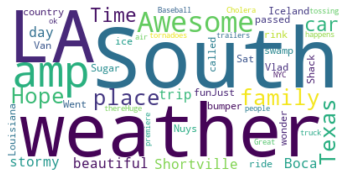

Cramer's coefficient = 0.36535, Percent Change = 0, Delay = 1, Size = 34


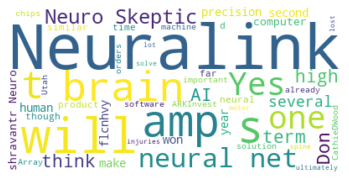

Cramer's coefficient = 0.35717, Percent Change = 0, Delay = 3, Size = 40


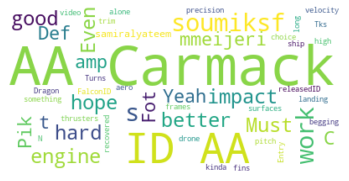

In [119]:
print("Cramer's coefficient = 0.41622, Percent Change = 1, Delay = 1, Size = 32")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 7)
print("Cramer's coefficient = 0.36535, Percent Change = 0, Delay = 1, Size = 34")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 9)
print("Cramer's coefficient = 0.35717, Percent Change = 0, Delay = 3, Size = 40")
correlation.generate_wordcloud(combined_w_sw, 'cluster_minilm_default', 0)

In [120]:
cramer_w_sw_sorted_size = cramer_w_sw.sort_values('size', ascending=False).reset_index(drop = True)
cramer_w_sw_sorted_size = cramer_w_sw_sorted_size.loc[(cramer_w_sw_sorted_size['size'] < 10000) & (cramer_w_sw_sorted_size['cluster'] != -1) &
(cramer_w_sw_sorted_size['cramer']>0)]
cramer_w_sw_sorted_size.head(25)

,method,cluster,type,cramer,percent_change,delay,size
200,cluster_distilbert_default,10,textblob_sentiment,0.01772,0,2,3182
201,cluster_distilbert_default,10,bertweet_sentiment,0.01769,0.5,1,3182
205,cluster_distilbert_default,10,textblob_sentiment,0.00306,1,1,3182
211,cluster_distilbert_default,10,bertweet_sentiment,0.00964,0.5,2,3182
212,cluster_distilbert_default,10,textblob_sentiment,0.01596,1,3,3182
213,cluster_distilbert_default,10,textblob_sentiment,0.01530,0,1,3182
218,cluster_distilbert_default,10,textblob_sentiment,0.01844,1,2,3182
221,cluster_distilbert_default,10,textblob_sentiment,0.01236,0.5,1,3182
224,cluster_distilbert_default,10,bertweet_sentiment,0.01896,1,2,3182
231,cluster_mpnet_default,5,textblob_sentiment,0.01469,0.5,3,3167


Cramer's coefficient = 0.01772, Percent Change = 0, Delay = 2, Size = 3182


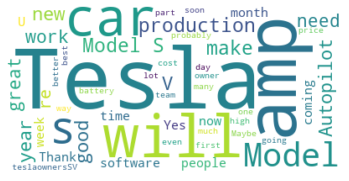

Cramer's coefficient = 0.01469, Percent Change = 0.5, Delay = 3, Size = 3167


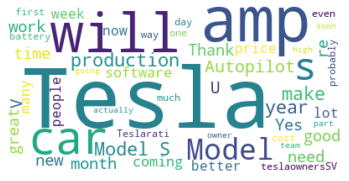

Cramer's coefficient = 0.01089, Percent Change = 1, Delay = 1, Size = 3097


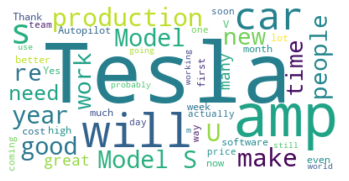

In [121]:
print("Cramer's coefficient = 0.01772, Percent Change = 0, Delay = 2, Size = 3182")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 10)
print("Cramer's coefficient = 0.01469, Percent Change = 0.5, Delay = 3, Size = 3167")
correlation.generate_wordcloud(combined_w_sw, 'cluster_mpnet_default', 5)
print("Cramer's coefficient = 0.01089, Percent Change = 1, Delay = 1, Size = 3097")
correlation.generate_wordcloud(combined_w_sw, 'cluster_use_default', 2)

## Analysis of tweets without stopwords

In [123]:
clusters_no_sw.columns

Index(['date', 'tweet', 'language', 'hashtags', 'cashtags', 'link', 'retweet',
       'nlikes', 'nreplies', 'nretweets', 'reply_to', 'cluster_bow_default',
       'cluster_bow_dbcv', 'cluster_tfidf_dbcv', 'cluster_word2vec_dbcv'],
      dtype='object')

In [122]:
combined_no_sw = combine_dataframes(clusters_no_sw, sentiments_no_sw)
methods_no_sw = ['cluster_bow_default', 'cluster_bow_dbcv', 'cluster_tfidf_dbcv', 'cluster_word2vec_dbcv']
cramer_no_sw = correlation.find_correlation(combined_no_sw, methods_no_sw).sort_values('cramer', ascending=False).reset_index(drop = True)
cramer_no_sw[['size']] = ''
for i in tqdm(range(0, cramer_no_sw.shape[0])):
    check = combined_no_sw.loc[combined_no_sw[cramer_no_sw.method[i]] == cramer_no_sw.cluster[i]]
    cramer_no_sw['size'][i] = check.shape[0]
cramer_no_sw

KeyError: 'cluster_use_default'